In [6]:
using DifferentialEquations, PyPlot, Statistics, LaTeXStrings, PyCall, LinearAlgebra, FFTW

In [7]:
ENV["PYTHON"] = "C:\\Users\\admin\\Anaconda3\\envs\\data_vis\\python.exe"

LogNorm = pyimport("matplotlib.colors").LogNorm
cmap = pyimport("cmap")

lajolla = cmap.Colormap("crameri:lajolla").to_mpl();
balance = cmap.Colormap("cmocean:balance").to_mpl();
oslo = cmap.Colormap("crameri:oslo").to_mpl();
lipari = cmap.Colormap("crameri:lipari").to_mpl();
eclipse = cmap.Colormap("cmasher:eclipse").to_mpl();
bilbao = cmap.Colormap("crameri:bilbao").to_mpl();


# Configure LaTeX rendering and fonts
PyPlot.matplotlib[:rc]("text", usetex=true)
PyPlot.matplotlib[:rc]("font", family="serif", serif=["mathpazo"], size=18)  # Base font size
PyPlot.matplotlib[:rc]("axes", titlesize=22)             # Axis title
PyPlot.matplotlib[:rc]("axes", labelsize=20)             # Axis labels
PyPlot.matplotlib[:rc]("xtick", labelsize=18)            # X-ticks
PyPlot.matplotlib[:rc]("ytick", labelsize=18)            # Y-ticks
PyPlot.matplotlib[:rc]("legend", fontsize=18)            # Legend
PyPlot.matplotlib[:rc]("figure", titlesize=24)           # Figure title
PyPlot.svg(true)
# LaTeX preamble packages
PyPlot.matplotlib[:rc]("text.latex", preamble="\\usepackage{amsmath}\\usepackage{amsfonts}\\usepackage{amssymb}\\usepackage{lmodern}")

In [8]:
""" 

######
        build Gell-Mann λ-matrices for the su(3) algebra (NOTE 1/2 factor)
#######

"""

λ1 = 1/2 * [0 1 0;
        1 0 0;
        0 0 0]

λ2 = 1/2*[0 -im  0;
        im  0  0;
        0   0  0]

λ3 = 1/2*[1  0 0;
        0 -1 0;
        0  0 0]

λ4 = 1/2*[0 0 1;
        0 0 0;
        1 0 0]

λ5 = 1/2*[0  0 -im;
        0  0   0;
        im 0   0]

λ6 = 1/2*[0 0 0;
        0 0 1;
        0 1 0]

λ7 = 1/2*[0  0   0;
        0  0  -im;
        0  im  0]
        
λ8 = (1/(2*sqrt(3)))*[1   0   0;
                0   1   0;
                0   0  -2]

                

λ_matrices = [λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8]

sum(λ_matrices[i]^2 for i in 1:8)


"""
    su3_d_tensor(lambdas::Vector{<:AbstractMatrix})

Compute the fully symmetric d_{i,j,k} tensor for SU(3) by
d[i,j,k] = 1/4 * tr( (lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]) * lambdas[k] ).
Returns an Array{Float64,3} of size (8,8,8).
"""
function su3_d_tensor(lambdas::Vector{Matrix{ComplexF64}})
    d = zeros(Float64, 8, 8, 8)
    for i in 1:8, j in 1:8, k in 1:8
        # compute the anticommutator {λ_i, λ_j}
        A = lambdas[i]*lambdas[j] + lambdas[j]*lambdas[i]

        d[i, j, k] = tr(A * lambdas[k]) / 4
    end
    return d
end

#Sum with cubic casimir of lambda matrices
dsu3 = su3_d_tensor(λ_matrices);

C3m = zeros(ComplexF64, 3, 3)

# sum over i,j,k
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k])
end
C3m

3×3 Matrix{ComplexF64}:
 0.138889+0.0im       0.0+0.0im       0.0+0.0im
      0.0+0.0im  0.138889+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  0.138889+0.0im

In [9]:
N1m = I(3)/3 + λ3 + 1/sqrt(3)*λ8
N0m = I(3)/3 - λ3 + 1/sqrt(3)*λ8
N2m = I(3)/3 - 2/sqrt(3)*λ8;

In [50]:
A = 0
γ = 0
β = 0
B = 0
C = sqrt(1-A^2-B^2)

a1 = A*B*cos(β)
a2 = A*B*sin(β)
a3 = 1/2*(A^2-B^2)
a4 = A*C*cos(γ)
a5 = A*C*sin(γ)
a6 = B*C*cos(γ-β)
a7 = B*C*sin(γ-β)
a8 = (-2+3*A^2+3B^2)/(2*sqrt(3))

# a1 = 0
# a2 = 0
# a3 = 0
# a4 = 0
# a5 = 0
# a6 = 0
# a7 = 0
# a8 = 0

# Definition of density matrix
rho0 = [1/3+a3+a8/sqrt(3) a1-im*a2 a4-im*a5;
a1+im*a2 1/3-a3+a8/sqrt(3) a6-im*a7;
a4+im*a5 a6+im*a7 1/3-2/sqrt(3)*a8]

# Physicality checks on rho & entries
det(rho0)
avec = [a1,a2,a3,a4,a5,a6,a7,a8]
sum(avec.^2)

0.3333333333333334

In [51]:
rho0

3×3 Matrix{ComplexF64}:
 -5.55112e-17+0.0im           0.0-0.0im  0.0-0.0im
          0.0+0.0im  -5.55112e-17+0.0im  0.0-0.0im
          0.0+0.0im           0.0+0.0im  1.0+0.0im

In [52]:
C3m = zeros(ComplexF64, 3, 3)
for i in 1:8, j in 1:8, k in 1:8
    C3m .+= (rho0 * dsu3[i, j, k] * (λ_matrices[i] * λ_matrices[j] * λ_matrices[k]))
end
tr(C3m)


# tr(rho0*λ8)

0.1388888888888889 + 0.0im

In [53]:
sum(λ_matrices[i]^2 for i in 1:8)

# C3m

3×3 Matrix{ComplexF64}:
 1.33333+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.33333+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.33333+0.0im

In [54]:
# Define the system of ODEs
function coupled_eqs!(du, u, p, t)
    Δ1, Δ2, g, φ, Δ, κ, η = p
    λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8, α_re, α_im = u

    # reconstruct complex field
    α    = α_re + im*α_im
    αc   = conj(α)
    expp = cis(φ)               # e^{iφ}
    expm = conj(expp)           # e^{-iφ}

    # λ-derivatives 
    dλ1 = -Δ1*λ2 + im*g*(λ3*(α-αc) + expm*αc/2*(-im*λ5+λ4) + expp*α/2*(-im*λ5-λ4))
    dλ2 =  Δ1*λ1 + im*g*(im*λ3*(α+αc) + expm*αc/2*(im*λ4+λ5) + expp*α/2*(im*λ4-λ5))
    dλ3 =  im*g*(-im*λ2*(α+αc) + λ1*(αc-α) + expm*αc/2*(im*λ7-λ6) + expp*α/2*(im*λ7+λ6))
    dλ4 = (-Δ1-Δ2)*λ5 + im*g*(αc/2*(im*λ7+λ6) + α/2*(im*λ7-λ6) + expm*αc/2*(-im*λ2-λ1) + expp*α/2*(-im*λ2+λ1))
    dλ5 = -(-Δ1-Δ2)*λ4 + im*g*(αc/2*(-im*λ6+λ7) + α/2*(-im*λ6-λ7) + expm*αc/2*(im*λ1-λ2) + expp*α/2*(im*λ1+λ2))
    dλ6 = -(Δ2)*λ7 + im*g* ( αc/2*(im*λ5-λ4) + α/2*(im*λ5+λ4) + 1/2*(expp*α - expm*αc)*(sqrt(3)*λ8 - λ3) )                 
    dλ7 =  (Δ2)*λ6 + im*g* ( αc/2*(-im*λ4-λ5) + α/2*(-im*λ4+λ5) + 1/2*(expp*α + expm*αc)*(im*sqrt(3)*λ8 - im*λ3) )
    dλ8 = -im*sqrt(3)/2*g*(αc*expm*(im*λ7-λ6) + α*expp*(im*λ7+λ6))

    du[1] = dλ1
    du[2] = dλ2
    du[3] = dλ3
    du[4] = dλ4
    du[5] = dλ5
    du[6] = dλ6
    du[7] = dλ7
    du[8] = dλ8

    # α-equation (split into real and imaginary parts)
    dα = (Δ*im - κ/2)*α - im*g*((λ1 - im*λ2) + expm*(λ6 - im*λ7)) + η
    du[9]  = real(dα)
    du[10] = imag(dα)
end  

coupled_eqs! (generic function with 1 method)

$\mathfrak{su}(3)$ quadratic and cubic Casimir operators $C_2$, $C_3$, define and check they remain constant over time

In [ ]:
# Fixed parameters
g, κ = 0.1, 1.0
Δ1, Δ2 = 0.1g,0.1*g #2π * 0.01*g , 2π * 0.10*g #, -2π *0.25*g
Δ = 0
ϕ = 0
η = 1.5*g 
# Time steps
tend = 200000.0/g;
t_list = range(0.0, tend, length=10001);

# Initial conditions
u0 = zeros(10);  
for i in 1:8
    u0[i] = tr(rho0*λ_matrices[i])
end

In [71]:
# Initial normalization checks: population, quadratic and cubic casimirs.
λt = sum([u0[i]^2 for i in 1:8])

C3 = 0
for i in 1:8, j in 1:8, k in 1:8
    C3 += sum(dsu3[i,j,k] * u0[i] * u0[j] * u0[k])
end



println("C₂ initial: ", λt)
println("C₃ initial: ", C3)
println("N₀ initial: ", (1/3 - u0[3] + 1/sqrt(3)*u0[8]))
println("N₁ initial: ", (1/3 + u0[3] + 1/sqrt(3)*u0[8]))
println("N₂ initial: ", (1/3 - 2/sqrt(3)*u0[8]))

C₂ initial: 0.33333333333333354
C₃ initial: 0.013888888888888907
N₀ initial: -1.6653345369377348e-16
N₁ initial: -1.6653345369377348e-16
N₂ initial: 1.0000000000000002


In [72]:
params = (Δ1, Δ2, g, ϕ, Δ, κ, η);
prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params);
sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-9, abstol=1e-9; maxiters=1e9);  # If stiff solver needed → pass "TRBDF2(autodiff=false)" to solve()

In [73]:

# extract your lambdas and times
λ = sol[1:8, :]         # 8×Nt array of λ₁..λ₈
t = sol.t               # time vector
Nt = length(t)

# Compute Ni and quadratic Casimir if needed
N0 = (1/3 .- sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N1 = (1/3 .+ sol[3,:] .+ 1/sqrt(3).*sol[8,:])
N2 =  (1/3 .- 2/sqrt(3).*sol[8,:])
Nt = N0 .+ N1 .+ N2
C2 = sum(λ .^ 2, dims=1)[:]   # quadratic Casimir


# cubic Casimir C3(t)
Ntsteps = length(sol.t)
dsu3 = su3_d_tensor(λ_matrices);
C3 = zeros(Float64, Ntsteps)
@inbounds for ti in 1:Ntsteps
    for i in 1:8, j in 1:8, k in 1:8
        C3[ti] += dsu3[i,j,k] * λ[i,ti] * λ[j,ti] * λ[k,ti]
    end
end

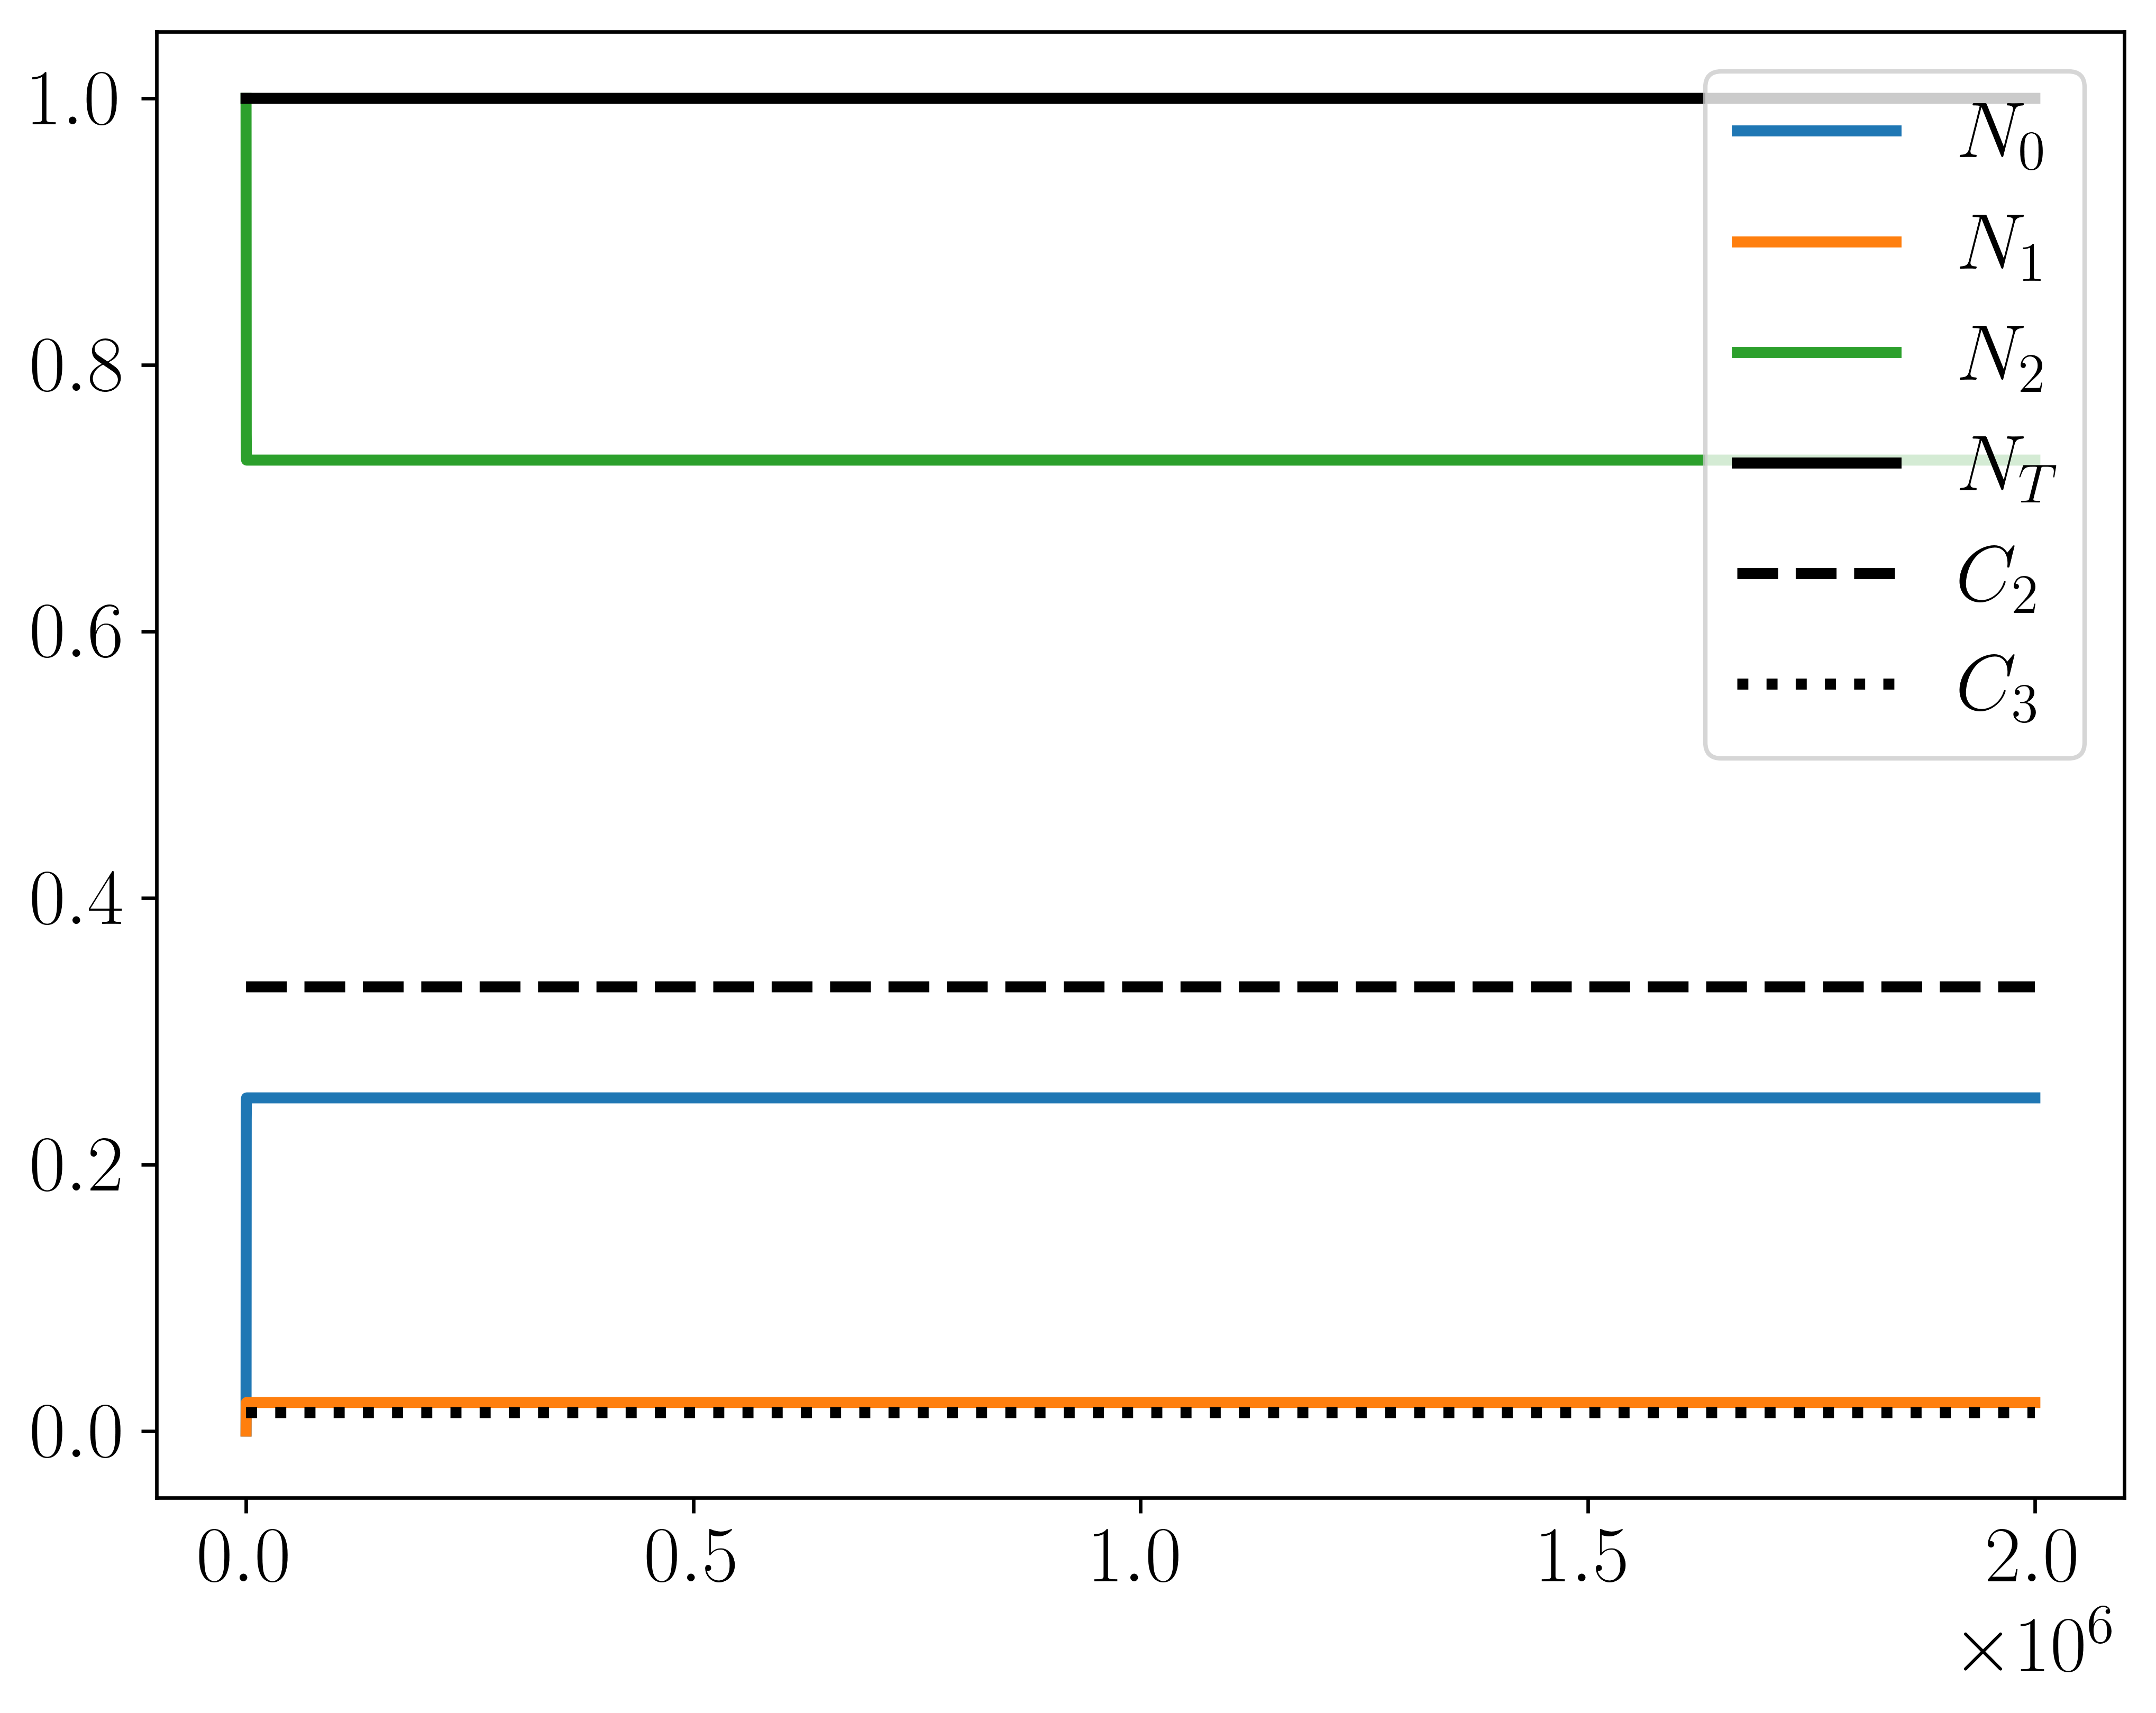

In [74]:
fig, ax= subplots(figsize=(8, 6), dpi=600)
ax.plot(t, N0, lw=2.5, label=L"N_0")
ax.plot(t, N1, lw=2.5, label=L"N_1")
ax.plot(t, N2, lw=2.5, label=L"N_2")
ax.plot(t, Nt, lw=2.5, linestyle="-", color="black", label=L"N_T")
ax.plot(t, C2, lw=2.5, linestyle="--", color="black", label=L"$C_2$")
ax.plot(t, C3, lw=2.5, linestyle=":", color="black", label=L"$C_3$")
# ax.plot(t, sol[1,:] + sol[6,:], label=L"1,6", lw=4)
# ax.plot(t, sol[3,:] + sqr't(3)*sol[8,:], label=L"3,8", lw4)
# ax.plot(t, sol[2,:] + sol[7,:], label=L"2,7", lw=4)
# ax.plot(t, (sol[1,:] .+ sol[6,:]).^2 + (sol[3,:] .+ sqrt(3)*sol[8,:]).^2 .+ (sol[2,:] .+ sol[7,:]).^2, label="tot", lw=4)
# ax.set_xscale("log")
ax.legend(loc="upper right")
display(fig)

In [711]:
#Sample data 


n = length(N1)

Fs = 1/(t[2] - t[1])  # Replace with your sampling frequency (Hz)

# Preprocess data
N0_detrend = N1 .- mean(N1)
window = 0.5 .* (1 .- cos.(2π .* (0:n-1) ./ (n-1)))
N0_windowed = N0_detrend .* window

# Compute FFT

fft_N0 = fft(N1)
mag = abs.(fft_N0)

# One-sided spectrum adjustment
if n % 2 == 0
    mag_one_sided = mag[1:(n÷2 + 1)]
    mag_one_sided[2:end-1] .*= 2
else
    mag_one_sided = mag[1:((n+1) ÷ 2)]
    mag_one_sided[2:end] .*= 2
end

# Frequency axis
freq = Fs .* (0:(length(mag_one_sided)-1)) ./ n


0.0:4.999500049995001e-5:0.24997500249975005

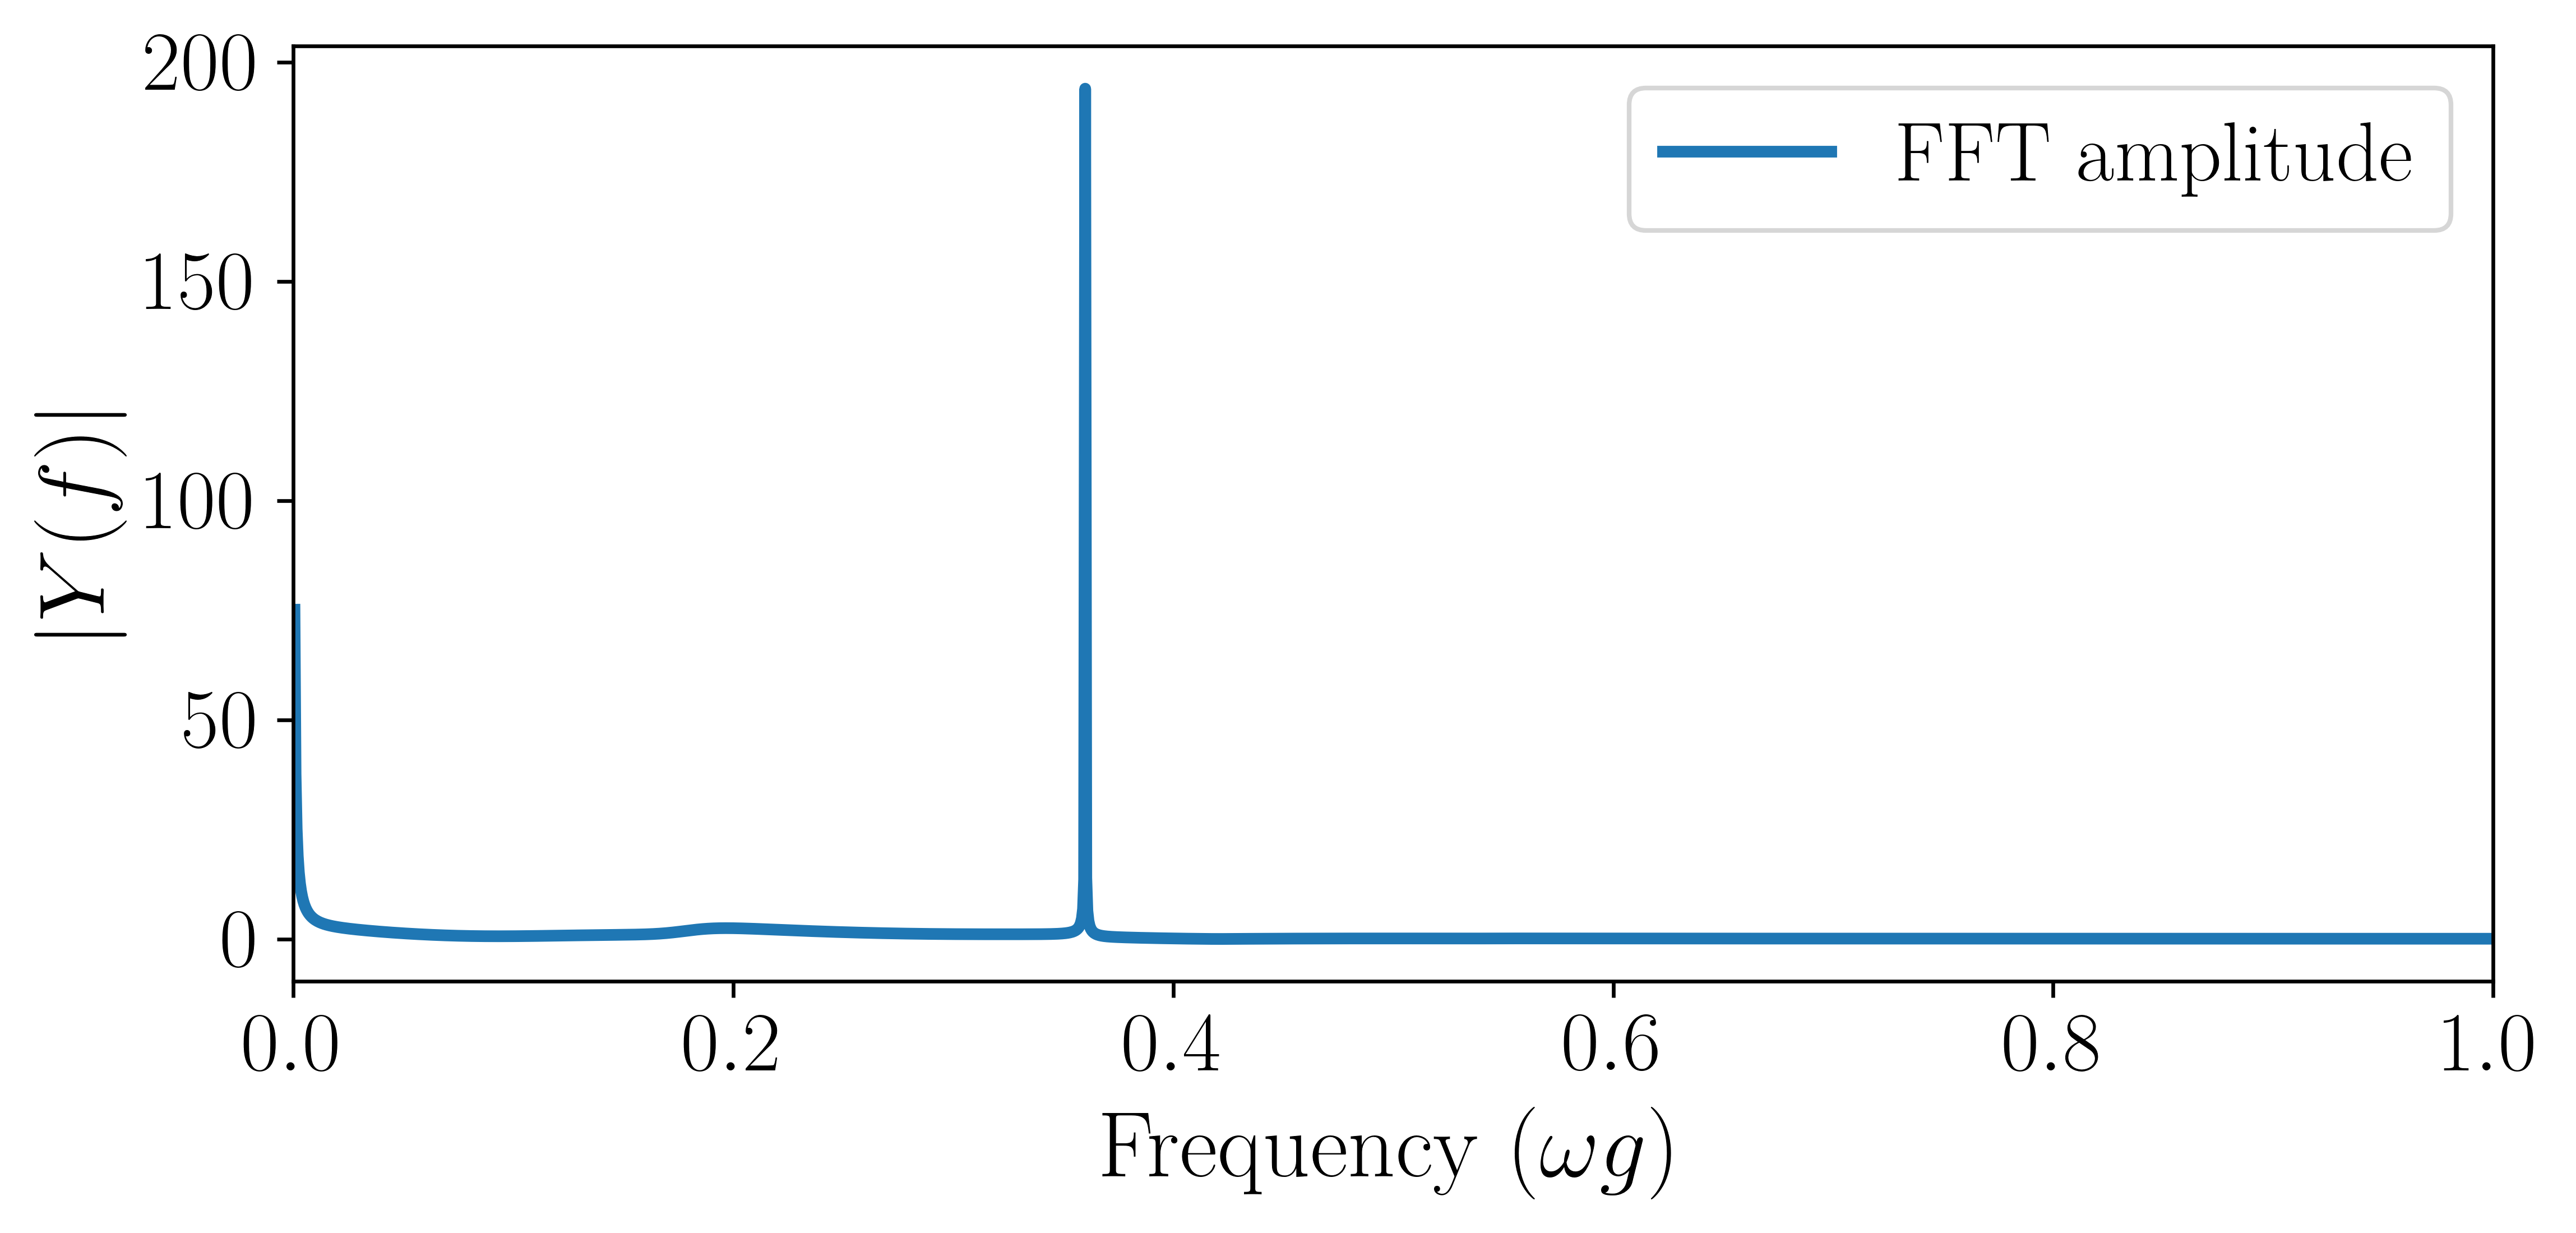

In [705]:
fig, ax = subplots(figsize=(8, 4), dpi=600)
plot(freq[2:end]./g, mag_one_sided[2:end],  label="FFT amplitude", lw=2.5)
argmax(sample)
xlim(0,1)
xlabel(L"Frequency $(\omega g)$")
ylabel(L"|Y(f)|")
legend()
tight_layout()
display(fig)

In [787]:
minimum(hcat(N0, N1, N2))

0.009999999999999985

Map out mean field phase diagram 

In [ ]:
# Parameter setup
η_vals = range(0.5*g, 2.5*g, length=41)
φ_vals = range(-π, π, length=41)
# Δ_vals = range(-1.0*g, 1.0*g, length=41)

# Preallocate variance and mean arrays
var_N0 = zeros(length(φ_vals), length(η_vals))
var_N1 = zeros(length(φ_vals), length(η_vals))
var_N2 = zeros(length(φ_vals), length(η_vals))
var_ax = zeros(length(φ_vals), length(η_vals))
var_ap = zeros(length(φ_vals), length(η_vals))
var_argcav = zeros(length(φ_vals), length(η_vals))


mean_N0 = zeros(length(φ_vals), length(η_vals))
mean_N1 = zeros(length(φ_vals), length(η_vals))
mean_N2 = zeros(length(φ_vals), length(η_vals))
mean_ax = zeros(length(φ_vals), length(η_vals))
mean_ap = zeros(length(φ_vals), length(η_vals))
mean_argcav = zeros(length(φ_vals), length(η_vals))


# coherence arrays
mean_rho01 = zeros(length(φ_vals), length(η_vals))
var_rho01  = zeros(length(φ_vals), length(η_vals))
mean_rho02 = zeros(length(φ_vals), length(η_vals))
var_rho02  = zeros(length(φ_vals), length(η_vals))
mean_rho12 = zeros(length(φ_vals), length(η_vals))
var_rho12  = zeros(length(φ_vals), length(η_vals))
# --------------------------------------------------

# Steady-state window: last 40% of the time series
total_pts = length(t_list)
ss_start = round(Int, 0.6 * total_pts):total_pts

# Loop over φ and η
for (i, φ_val) in enumerate(φ_vals)
    for (j, η_val) in enumerate(η_vals)
        # Update parameters and initial condition
        params = (0.12g, 0.08*g, g, φ_val, Δ, κ, η_val)
        prob = ODEProblem(coupled_eqs!, u0, (0.0, tend), params)

        # Solve
        sol = solve(prob, Tsit5(), saveat=t_list, reltol=1e-6, abstol=1e-6)



        # Extract steady-state data
        N0_ss =  1/3 .- sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N1_ss = 1/3 .+ sol[3,ss_start] + 1/sqrt(3) .* sol[8,ss_start];
        N2_ss = 1/3 .- 2/sqrt(3) .* sol[8,:];
        ax_ss = sol[end-1,ss_start]
        ap_ss = sol[end,ss_start]
        argcav_ss = atan.(ap_ss, ax_ss)  # Argument of the cavity field

        
        λ1_ss = sol[1, ss_start]
        λ2_ss = sol[2, ss_start]
        λ4_ss = sol[4, ss_start]
        λ5_ss = sol[5, ss_start]
        λ6_ss = sol[6, ss_start]
        λ7_ss = sol[7, ss_start]

        # --- build coherences in SS window
        rho01_ss = @. (λ1_ss + im*λ2_ss) / 2
        rho02_ss = @. (λ6_ss + im*λ7_ss) / 2
        rho12_ss = @. (λ4_ss + im*λ5_ss) / 2
    
        # --- record mean and variance of the absolute value
        mean_rho01[i,j] = mean(abs.(rho01_ss))
        var_rho01[i,j]  = var(abs.(rho01_ss))
    
        mean_rho02[i,j] = mean(abs.(rho02_ss))
        var_rho02[i,j]  = var(abs.(rho02_ss))
    
        mean_rho12[i,j] = mean(abs.(rho12_ss))
        var_rho12[i,j]  = var(abs.(rho12_ss))
        # Compute variances and mean
        var_N0[i, j] = var(N0_ss)
        var_N1[i, j] = var(N1_ss)
        var_N2[i, j] = var(N2_ss)
        var_ax[i, j] = var(ax_ss)
        var_ap[i, j] = var(ap_ss)
        var_argcav[i, j] = var(argcav_ss)

        # Compute means
        mean_N0[i,j] = mean(N0_ss)
        mean_N1[i,j] = mean(N1_ss)
        mean_N2[i,j] = mean(N2_ss)
        mean_ax[i,j] = mean(ax_ss)
        mean_ap[i,j] = mean(ap_ss)
        mean_argcav[i,j] = mean(argcav_ss)
    end
end

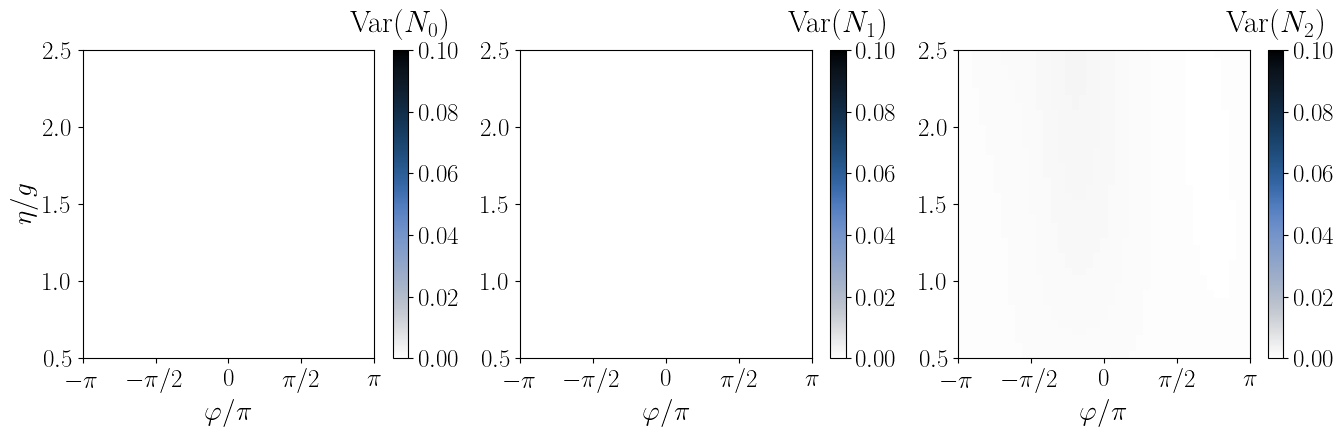

In [726]:
"""
Plot the variance phase diagram for a given N_i.

"""
x = φ_vals./π
y = η_vals./g
# x = Δ_vals./g
# clims =  (0,0.1) #(1e-3, 1e-0) 
cmap = oslo.reversed()

xtick_locs = [-1.0, -0.5, 0.0, 0.5, 1.0]  # x = φ/π
xtick_labels = [L"-\pi", L"-\pi/2", L"0", L"\pi/2", L"\pi"]


fig, axs = subplots(1, 3, figsize=(16, 4))


im1 = axs[1].imshow((var_N0)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim = clims)     
axs[1].set_ylabel(L"\eta/g")
axs[1].set_xlabel(L"\varphi/\pi")
#axs[1].set_xlabel(L"\Delta_s/g")
axs[1].set_xticks(xtick_locs)
axs[1].set_xticklabels(xtick_labels)


im2 = axs[2].imshow((var_N1)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[2].set_ylabel(L"\eta/g")
 axs[2].set_xlabel(L"\varphi/\pi")
#axs[2].set_xlabel(L"\Delta_s/g")
axs[2].set_xticks(xtick_locs)
axs[2].set_xticklabels(xtick_labels)

im3 = axs[3].imshow((var_N2)',
                     extent=(minimum(x), maximum(x), minimum(y), maximum(y)),
                     origin="lower",
                     aspect="auto", cmap=cmap, clim=clims)     
# axs[3].set_ylabel(L"\eta/g")
 axs[3].set_xlabel(L"\varphi/\pi")
#axs[3].set_xlabel(L"\Delta_s/g")
axs[3].set_xticks(xtick_locs)
axs[3].set_xticklabels(xtick_labels)

cbar1 = colorbar(im1, ax=axs[1])
cbar2 = colorbar(im2, ax=axs[2])
cbar3 = colorbar(im3, ax=axs[3])
#Set colorbar label as the variance of N1 and N2, horizontally aligned on top of the colorbar
cbar1.ax.set_title(L"\mathrm{Var}(N_0)", pad=13)
cbar2.ax.set_title(L"\mathrm{Var}(N_1)", pad=13)
cbar3.ax.set_title(L"\mathrm{Var}(N_2)", pad=13)

# cbar1.ax.set_title(L"\langle N_0\rangle", pad=13)
# cbar2.ax.set_title(L"\langle N_1\rangle", pad=13)
# cbar3.ax.set_title(L"\langle N_2\rangle", pad=13)
display(fig)
# savefig("var_N0_N1_N2.pdf", bbox_inches="tight", dpi=600)